In [ ]:
!pip install deepface opencv-python-headless matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.5 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=da36c16160db0c9d6a54924e7799e34d751234d2fd4489390e696ae2b98704d4
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


Sistema pronto! Use os botões na visualização da webcam.
⚠️ Nenhuma pessoa cadastrada ainda!
25-07-11 17:44:48 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:00<00:00, 117MB/s]


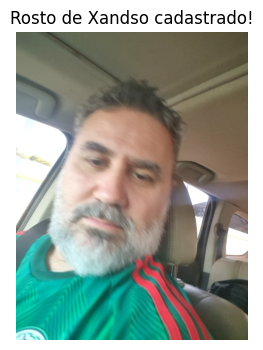

✅ Xandso cadastrado com sucesso!
Dimensão do embedding: 128


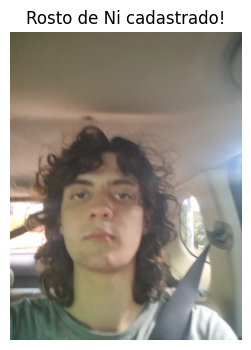

✅ Ni cadastrado com sucesso!
Dimensão do embedding: 128


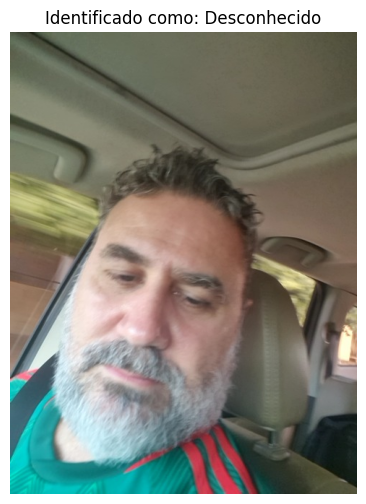

🔍 Identificação: Desconhecido


In [ ]:

import cv2
import numpy as np
import sqlite3
from deepface import DeepFace
from IPython.display import display, HTML
from base64 import b64decode
import matplotlib.pyplot as plt
from google.colab import output
import pandas as pd

# ======================
# CLASSE DO BANCO DE DADOS
# ======================
class FaceDatabase:
    def __init__(self, db_path='face_db.db'):
        self.conn = sqlite3.connect(db_path)
        self.cursor = self.conn.cursor()
        self.create_table()

    def create_table(self):
        self.cursor.execute('''CREATE TABLE IF NOT EXISTS faces
                            (id INTEGER PRIMARY KEY, name TEXT, embedding BLOB)''')
        self.conn.commit()

    def add_face(self, name, embedding):
        # Garantir que o embedding seja sempre 1D e do tipo float32
        embedding = np.array(embedding, dtype=np.float32).flatten()
        self.cursor.execute("INSERT INTO faces (name, embedding) VALUES (?, ?)",
                          (name, embedding.tobytes()))
        self.conn.commit()

    def get_all_faces(self):
        self.cursor.execute("SELECT name, embedding FROM faces")
        return [(row[0], np.frombuffer(row[1], dtype=np.float32)) for row in self.cursor.fetchall()]

    def list_registered_names(self):
        self.cursor.execute("SELECT name FROM faces")
        return [row[0] for row in self.cursor.fetchall()]

    def find_match(self, target_embedding, threshold=0.6):
        best_match = None
        best_similarity = 0

        # Normalizar o embedding de entrada
        target_embedding = np.array(target_embedding, dtype=np.float32).flatten()

        for name, db_embedding in self.get_all_faces():
            # Garantir compatibilidade de dimensões
            if db_embedding.shape != target_embedding.shape:
                continue

            similarity = self.cosine_similarity(target_embedding, db_embedding)
            if similarity > best_similarity:
                best_similarity = similarity
                best_match = name

        return best_match if best_similarity > threshold else "Desconhecido"

    @staticmethod
    def cosine_similarity(embedding1, embedding2):
        dot_product = np.dot(embedding1, embedding2)
        norm1 = np.linalg.norm(embedding1)
        norm2 = np.linalg.norm(embedding2)
        return dot_product / (norm1 * norm2) if norm1 != 0 and norm2 != 0 else 0

# =============================
# SISTEMA DE RECONHECIMENTO FACIAL
# =============================
class FaceRecognitionSystem:
    def __init__(self):
        self.db = FaceDatabase()
        self.setup_webcam()

    def setup_webcam(self):
        # Interface com botões separados
        display(HTML('''
        <style>
            .btn-container {
                margin: 10px 0;
                display: flex;
                gap: 10px;
                flex-wrap: wrap;
            }
            button {
                padding: 8px 12px;
                background-color: #4CAF50;
                color: white;
                border: none;
                border-radius: 4px;
                cursor: pointer;
            }
            button:hover {
                background-color: #45a049;
            }
            input {
                padding: 8px;
                border: 1px solid #ccc;
                border-radius: 4px;
            }
        </style>

        <video id="video" width="640" height="480" autoplay></video>
        <div class="btn-container">
            <input type="text" id="nameInput" placeholder="Digite o nome para cadastrar">
            <button id="registerBtn">Cadastrar Pessoa</button>
            <button id="recognizeBtn">Reconhecer Pessoa</button>
            <button id="listBtn">Listar Cadastrados</button>
        </div>
        <div id="results"></div>

        <script>
            const video = document.getElementById('video');
            navigator.mediaDevices.getUserMedia({ video: true })
                .then(stream => video.srcObject = stream);

            function captureImage() {
                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                return canvas.toDataURL('image/jpeg');
            }

            document.getElementById('registerBtn').onclick = () => {
                const name = document.getElementById('nameInput').value;
                if (!name) {
                    alert('Digite um nome antes de cadastrar!');
                    return;
                }
                const imgData = captureImage();
                google.colab.kernel.invokeFunction('registerFace', [name, imgData], {});
            };

            document.getElementById('recognizeBtn').onclick = () => {
                const imgData = captureImage();
                google.colab.kernel.invokeFunction('recognizeFace', [imgData], {});
            };

            document.getElementById('listBtn').onclick = () => {
                google.colab.kernel.invokeFunction('listRegistered', [], {});
            };
        </script>
        '''))

    def register_face(self, name, img_data):
        try:
            img_bytes = b64decode(img_data.split(',')[1])
            nparr = np.frombuffer(img_bytes, np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

            # Salvar imagem temporariamente
            temp_path = f"temp_face_{name.replace(' ', '_')}.jpg"
            cv2.imwrite(temp_path, img)

            # Extrair embedding com modelo consistente
            embedding = DeepFace.represent(
                img_path=temp_path,
                model_name='Facenet',  # Modelo mais estável (512 dimensões)
                enforce_detection=False,
                detector_backend='opencv'
            )[0]["embedding"]

            # Adicionar ao banco de dados
            self.db.add_face(name, embedding)

            # Mostrar preview
            plt.figure(figsize=(6, 4))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"Rosto de {name} cadastrado!")
            plt.axis('off')
            plt.show()

            print(f"✅ {name} cadastrado com sucesso!")
            print(f"Dimensão do embedding: {len(embedding)}")
        except Exception as e:
            print(f"❌ Erro no cadastro: {str(e)}")

    def recognize_face(self, img_data):
        try:
            img_bytes = b64decode(img_data.split(',')[1])
            nparr = np.frombuffer(img_bytes, np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
            temp_path = "temp_recognition.jpg"
            cv2.imwrite(temp_path, img)

            # Extrair embedding com o mesmo modelo
            embedding = DeepFace.represent(
                img_path=temp_path,
                model_name='Facenet',  # Mesmo modelo usado no cadastro
                enforce_detection=False,
                detector_backend='opencv'
            )[0]["embedding"]

            # Buscar correspondência
            identity = self.db.find_match(embedding)

            # Detectar rostos para visualização
            try:
                faces = DeepFace.extract_faces(temp_path, detector_backend='opencv')
                for face in faces:
                    x, y, w, h = face['facial_area'].values()
                    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    cv2.putText(img, identity, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)
            except:
                pass

            # Mostrar resultado
            plt.figure(figsize=(8, 6))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"Identificado como: {identity}")
            plt.axis('off')
            plt.show()

            print(f"🔍 Identificação: {identity}")
        except Exception as e:
            print(f"❌ Erro no reconhecimento: {str(e)}")

    def list_registered(self):
        """Lista todas as pessoas cadastradas no banco de dados"""
        try:
            names = self.db.list_registered_names()
            if names:
                print("\n" + "="*50)
                print("👥 PESSOAS CADASTRADAS:")
                print("="*50)

                # Exibir como lista numerada
                for i, name in enumerate(names, 1):
                    print(f"{i}. {name}")

                # Exibir como tabela HTML
                display(HTML(self.create_names_table(names)))

                print(f"\nTotal de pessoas cadastradas: {len(names)}")
            else:
                print("⚠️ Nenhuma pessoa cadastrada ainda!")
        except Exception as e:
            print(f"❌ Erro ao listar cadastrados: {str(e)}")

    def create_names_table(self, names):
        """Cria uma tabela HTML estilizada com os nomes cadastrados"""
        table_html = """
        <style>
            .names-table {
                width: 300px;
                border-collapse: collapse;
                margin: 15px 0;
                box-shadow: 0 2px 8px rgba(0,0,0,0.1);
                font-family: Arial, sans-serif;
            }
            .names-table th {
                background-color: #4CAF50;
                color: white;
                text-align: left;
                padding: 10px;
            }
            .names-table td {
                padding: 8px 10px;
                border-bottom: 1px solid #ddd;
            }
            .names-table tr:nth-child(even) {
                background-color: #000000;
            }
            .names-table tr:hover {
                background-color: #000000;
            }
        </style>
        <table class="names-table">
            <tr>
                <th>ID</th>
                <th>Nome</th>
            </tr>
        """

        for i, name in enumerate(names, 1):
            table_html += f"""
            <tr>
                <td>{i}</td>
                <td>{name}</td>
            </tr>
            """

        table_html += "</table>"
        return table_html

# ======================
# INICIALIZAÇÃO DO SISTEMA
# ======================
# Criar instância do sistema
face_system = FaceRecognitionSystem()

# Registrar callbacks
output.register_callback('registerFace', face_system.register_face)
output.register_callback('recognizeFace', face_system.recognize_face)
output.register_callback('listRegistered', face_system.list_registered)

print("Sistema pronto! Use os botões na visualização da webcam.")